# Techcore Experience

---

## frAPI Benchmark

In [1]:
import time
import glob
import base64
import asyncio
import numpy as np
import requests as req
from pathlib import Path
import matplotlib.pyplot as plt

### Checking connection status from frAPI

In [2]:
resp = req.get('http://35.237.84.73/frapi/status')
print(resp)

<Response [200]>


---
#  Defining functions

In [5]:
def get_base64(image_path):
    with open(image_path, 'rb') as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

In [6]:
def image_num(id):
    num = int(id)
    if num < 10:
        return f'000{num}'
    elif num < 100:
        return f'00{num}'
    else:
        return num

In [7]:
def img_name(name, id):
    return f'{name}_{image_num(id)}.jpg'

In [8]:
def img_path_matched_pair(pair):
    first_name = img_name(pair[0], pair[1])
    second_name = img_name(pair[0], pair[2])
    
    first_path = Path(Path('dataset'), pair[0], first_name)
    second_path = Path(Path('dataset'), pair[0], second_name)
    
    return first_path, second_path

In [9]:
def img_path_mismatched_pair(pair):
    first_name = img_name(pair[0], pair[1])
    second_name = img_name(pair[2], pair[3])
    
    first_path = Path(Path('dataset'), pair[0], first_name)
    second_path = Path(Path('dataset'), pair[2], second_name)
    
    return first_path, second_path

In [10]:
def get_matched_pairs_similarity_scores(matched_pairs):
    scores = []
    
    print('Loading...')
    
    for pair in matched_pairs:
        first_path, second_path = img_path_matched_pair(pair)

        req_body = {
            'image_b641': get_base64(first_path),
            'image_b642': get_base64(second_path),
        }

        resp = req.post('http://35.237.84.73/frapi/verify/images', json = req_body)
        scores.append(resp.json()['similarity_score'])
    
    print('Done...')
    return scores

In [11]:
def get_mismatched_pairs_similarity_scores(mismatched_pairs):
    scores = []
    print('Loading...')
    
    for pair in mismatched_pairs:
        first_path, second_path = img_path_mismatched_pair(pair)

        req_body = {
            'image_b641': get_base64(first_path),
            'image_b642': get_base64(second_path)
        }
        
        resp = req.post('http://35.237.84.73/frapi/verify/images', json = req_body)
        scores.append(resp.json()['similarity_score'])
    
    print('Done...')
    return scores

In [49]:
def array_file(arr, fname):
    file = open(f'{fname}.txt', 'w')
    np.savetxt(file, arr)
    file.close()

In [12]:
def min_max(arr):
    min = arr[0]
    max = arr[0]

    for num in arr:
        if num < min:
            min = num
        elif num > max:
            max = num;
    return min, max

In [13]:
def normalize(arr):
    min, max = min_max(arr)

    res = []
    for num in arr:
        res.append((num - min) / (max - min))

    return res

### Loading arrays

using original mismatched_pairs.txt, Chen_Tsai-chin-1-Mamouh_Habib-1 line 95 returned an error with no similarity_score attribute on reponse. had to change to something random (Georgia_Giddings) to work

In [14]:
matched_pairs = np.loadtxt(Path('matched_pairs.txt'), dtype='str')
mismatched_pairs = np.loadtxt(Path('mismatched_pairs.txt'), dtype='str')

It takes around 5min to complete all 300 requests and populate ***matched_pairs_scores*** array

In [21]:
start = time.time()
matched_pairs_scores = get_matched_pairs_similarity_scores(matched_pairs)
elapsed = time.time() - start

print(f'Elapsed time: {int(elapsed)}s')
print('Score array length: ', len(matched_pairs_scores))

Loading...
Done...
Elapsed time: 295s
Score array length:  300


In [30]:
start = time.time()
mismatched_pairs_scores = get_mismatched_pairs_similarity_scores(mismatched_pairs)
elapsed = time.time() - start

print(f'Elapsed time: {int(elapsed)}s')
print('Score array length: ', len(matched_pairs_scores))

Loading...
Done...
Elapsed time: 293s
Score array length:  300


### Saving arrays into files
so it's not necessary to make the same request everytime

In [46]:
array_file(matched_pairs_scores, 'matched_scores')
array_file(mismatched_pairs_scores, 'mismatched_scores')

### Loading array from files

In [51]:
matched_scores_arr = np.loadtxt('matched_scores.txt')
mismatched_scores_arr = np.loadtxt('mismatched_scores.txt')

### False Rejection Rate (FRR)

In [53]:
x_frr = []
y_frr = []

cp = len(matched_scores_arr) 

for x in range(20, 101):
    fn = 0
    for score in matched_scores_arr:
        if score < x:
            fn += 1

    tp = cp - fn
    fnr = fn / cp

    frr = fnr * fn / (tp + fn)
    x_frr.append(x)
    y_frr.append(frr)

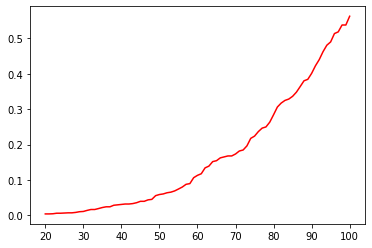

In [54]:
plt.plot(x_frr, y_frr, 'r')

### False Acceptance Rate (FAR)

In [55]:
x_far = []
y_far = []

cp = len(mismatched_scores_arr)

for x in range(-100, -19):
    fp = 0
    for score in mismatched_scores_arr:
        if score > x:
            fp += 1
    fpr = fp / cp
    x_far.append(x)
    y_far.append(fpr)

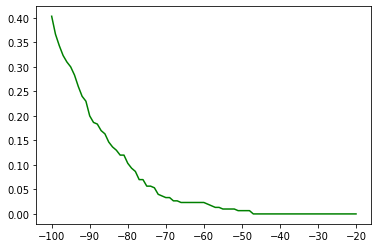

In [56]:
plt.plot(x_far, y_far, 'g')

### FRR x FAR 

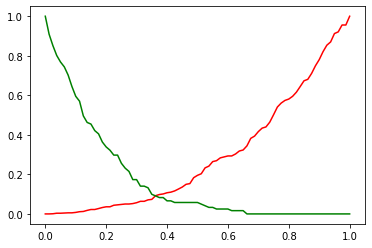

In [57]:
plt.plot(normalize(x_frr), normalize(y_frr), 'r', normalize(x_far), normalize(y_far), 'g')